In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

/Users/admin/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
lar_loss = pd.read_csv('new_claimdata_1.csv')

In [3]:
lar_loss['Issued_Time'] = [item.replace(':','') for item in list(lar_loss['Issued_Time'].values)]

In [4]:
lar_loss['Issued_Time'] = lar_loss['Issued_Time'].astype(int)

In [5]:
def date_lst(feature):
    date = [int(item[-2:]) for item in list(lar_loss[feature].values)]
    lar_loss[feature] = date
    return lar_loss[feature].head()

In [6]:
date_lst('Issued_date')
date_lst('Inception_date')
date_lst('Event_Occurrence_date')
date_lst('Effective_date')

0    10
1     1
2     1
3    26
4    15
Name: Effective_date, dtype: int64

In [7]:
lar_loss['Insured_Age_Range'] = lar_loss['Insured_Age_Range'].replace(['30-39','40-49','60-','50-59','20-29','00-19'],
                                                       [3039,4049,60,5059,2029,19])

In [8]:
lar_loss['Claim_Number'] = lar_loss['Claim_Number'].fillna(0.0)
lar_loss['Contract_Status'] = lar_loss['Contract_Status'].fillna(0.0)

In [9]:
columns = list(lar_loss.columns)

# Define features and target variable

In [10]:
feature_lst = ['EV_LARGE','Issued_Date','Effective_Date','Prefecture','Region','Inception_Month',
               'Event_Occurrence_Month','Car_Name','Event_Occurrence','Inception','Effective','Issued','Reason']
                                                                                         
features_to_use = [col for col in columns if col not in feature_lst]

In [11]:
X = lar_loss[features_to_use]
y = lar_loss['EV_LARGE']

# Build a forest and compute the feature importances


In [14]:
forest = ExtraTreesClassifier(n_estimators=29,
                              random_state=0)

In [17]:
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=29, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [23]:
import numpy as np
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. Incurred (0.101600)
2. Claim_Number (0.030569)
3. Event_Number (0.025748)
4. Event_Occurrence_month (0.024264)
5. Effective_date (0.023862)
6. Insured_Age (0.023128)
7. Issued_date (0.022785)
8. Issued_Time (0.022509)
9. Annual_Premium (0.022473)
10. Car_Age (0.022391)
11. Annual_Premium_BIL (0.021977)
12. Annual_Premium_PDL (0.021589)
13. Annual_Premium_PPA (0.021286)
14. Issued_month (0.021183)
15. Effective_month (0.021054)
16. Inception_month (0.020746)
17. Original_Channel (0.020224)
18. Renewal_Times (0.019715)
19. Annual_Premium_PI (0.019645)
20. Bonus_Malus (0.019541)
21. Insured_Age_Range (0.018320)
22. Car_Type (0.018212)
23. Family_Restriction (0.018116)
24. Bonus_Malus_Range (0.017418)
25. Mileage (0.017395)
26. Annual_Premium_ODPE (0.017355)
27. PI_Class (0.017312)
28. Annual_Premium_OD (0.017210)
29. Annual_Premium_PE (0.017064)
30. PI_Limit (0.016767)
31. Payment_Method (0.016075)
32. Prev_Insurer_Category (0.015293)
33. Contract_Status (0.015207)
34.

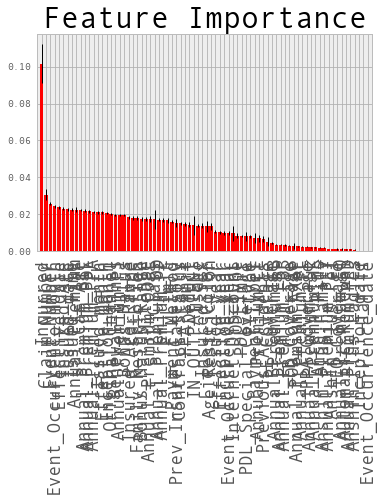

In [21]:
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.title("Feature Importance", size = 30)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], size =18)
plt.xlim([-1, X.shape[1]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

# Modeling 

In [24]:
# RanfomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
random_state = 5000
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.34, random_state = 5000)
rf1 = RandomForestClassifier(n_estimators=250, criterion='entropy',  n_jobs = 1,  random_state=random_state)
rf1.fit(X_train, y_train)
y_val_pred = rf1.predict_proba(X_val)
y_val_pred_acc = rf1.predict(X_val)
logloss = log_loss(y_val, y_val_pred)
print(logloss)
accuracy = accuracy_score(y_val, y_val_pred_acc)
print(accuracy)

0.126876574986
0.963791605875


In [25]:
# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(seed=random_state)
xgb.fit(X_train, y_train)
y_val_pred = xgb.predict_proba(X_val)
y_val_pred_acc = xgb.predict(X_val)
logloss = log_loss(y_val, y_val_pred)
print(logloss)
accuracy = accuracy_score(y_val, y_val_pred_acc)
print(accuracy)

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.223528514681
0.924205351212


# AUC 

In [13]:
# RanfomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
random_state = 5000
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.34, random_state = 5000)
rf1 = RandomForestClassifier(n_estimators=250, criterion='entropy',  n_jobs = 1,  random_state=random_state)
rf1.fit(X_train, y_train)
y_val_pred_prob = rf1.predict_proba(X_val)

In [14]:
roc_auc_score(y_val, y_val_pred_prob[:, 1])

0.96921798898262401

In [16]:
# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(seed=random_state)
xgb.fit(X_train, y_train)
y_scores = xgb.predict_proba(X_val)

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
roc_auc_score(y_val, y_scores[:, 1])

0.84603117434945563